*Credit to the repo that inspires the DQNAgent and the training: https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN*

In [1]:
import random
import numpy as np
import cv2

from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Track generation: 948..1196 -> 248-tiles track


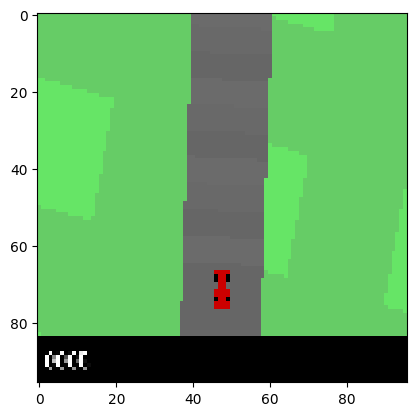

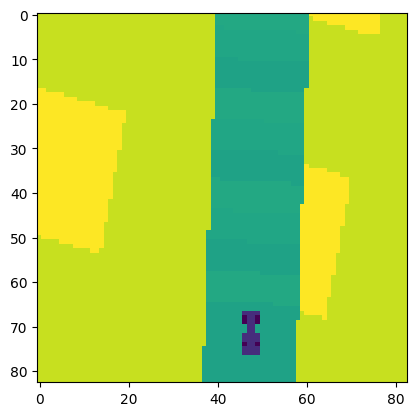

In [8]:
from gym.envs.box2d.car_racing import CarRacing
import matplotlib.pyplot as plt

def image_processing(image, height=83, width=83):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype(float)
    image /= 255.0
    image = image[:height, :width]
    return image

env = CarRacing()
env.reset()
for _ in range(50):
    env.step(None)
init_state, _, _, _ = env.step(None)
env.close()

plt.imshow(init_state)
plt.show()

processed_image = image_processing(init_state, 83, 83)

plt.imshow(processed_image, cmap="Greys")
plt.show()

In [16]:
import math

def dim_encoder(Hin, Win, padding, dilation, kernel_size, stride):
    Hout = (Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1
    Wout = (Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1
    return math.floor(Hout), math.floor(Wout)

Hin, Win = 83, 83
Hout, Wout = dim_encoder(Hin, Win, padding=(0, 0), dilation=(1, 1), kernel_size=(7, 7), stride=(3, 3))
Hout, Wout = math.floor(Hout/2), math.floor(Wout/2)
Hout, Wout = dim_encoder(Hout, Wout, padding=(0, 0), dilation=(1, 1), kernel_size=(4, 4), stride=(1, 1))
Hout, Wout = math.floor(Hout/2), math.floor(Wout/2)

print(Hout, Wout)

5 5


In [17]:
class DQN(nn.Module):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, 7, stride=3),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 12, 4),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(5 * 5 * 12, 256),
            nn.ReLU(True),
            nn.Linear(256, len(action_space))
        )
        
    def forward(self, X):
        X = self.conv_layers(X)
        X = self.flatten(X)
        X = self.fully_connected_layers(X)
        
        return X
    
    
class DQNAgent:
    def __init__(self, lr=0.001, weight_decay=1e-5, epochs=1, batch_size=128, memory_size=5000, epsilon=0.98, gamma=0.9):        
        self.action_space = [
            (0, 1, 0), (-1, 0, 0), 
            (1, 0, 0), (0, 0, 1),
        ]
        
        # Memory for the experience replay
        self.memory = deque(maxlen=memory_size)
        # Gamma for the Q update
        self.gamma = gamma
        # Epsilon to deal with the exploration/explotation trade-off
        self.espilon = epsilon
        
        # Models of the agent
        self.model = DQN(self.action_space).to(device)
        self.target = DQN(self.action_space).to(device)
        self.optim_model = optim.Adam(params=self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.optim_target = optim.Adam(params=self.target.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss = nn.MSELoss()
        self.epochs = epochs
        self.batch_size = batch_size
        
    def play_action(self, state):
        # Exploitation
        if np.random.rand() < self.espilon:
            state = np.expand_dims(state, axis=0)
            state = torch.from_numpy(state.astype('float32')).unsqueeze(dim=0)
            state = state.to(device)
            actions = self.model(state).cpu().detach().numpy()
            action = np.argmax(actions)
        # Exploration
        else:
            action = np.random.randint(0, len(self.action_space))

        return self.action_space[action]
    
    def fit(self, X, y):
        X = torch.from_numpy(X.astype('float32')).to(device)
        y = torch.from_numpy(y.astype('float32'))
        
        for _ in range(self.epochs):
            y_pred = self.model(X).cpu()
            loss = self.loss(y_pred, y)
            self.optim_model.zero_grad()
            loss.backward()
            self.optim_model.step()
            
    def replay_memory(self):
        # Random selection from memory to create a batch of data
        minibatch = random.sample(self.memory, self.batch_size)
        train_state = []
        train_target = []
        
        for state, action, reward, next_state, terminate in minibatch:
            # Prediction of the target
            state = np.expand_dims(state, axis=0)
            state_ten = torch.from_numpy(state.astype('float32')).unsqueeze(dim=0).to(device)
            target = self.model(state_ten).cpu().detach().numpy()[0]
            if terminate:
                target[action] = reward
            # Update of the target according to the next state
            else:
                next_state = np.expand_dims(next_state, axis=0)
                next_state_ten = torch.from_numpy(next_state.astype('float32')).unsqueeze(dim=0).to(device)
                t = self.target(next_state_ten).cpu().detach().numpy()[0]
                target[action] = reward + self.gamma * np.amax(t)
            train_state.append(state)
            train_target.append(target)
        # Gradient descent
        self.fit(np.array(train_state), np.array(train_target))
            
    def memorize(self, state, action, reward, next_state, terminate):
        self.memory.append((state, self.action_space.index(action), reward, next_state, terminate))
        
    def update_target(self):
        self.target.load_state_dict(self.model.state_dict())
            


In [18]:
import gym
import logging
import traceback

EPISODES = 500
BATCH_SIZE = 128
UPDATE_TARGET_FREQUENCY = 5

env = gym.make("CarRacing-v0")
car = DQNAgent()
reward_history = []

file = open("logs/dqn/dqn_0.90_log.txt", "w")

try:
    for eps in range(1, EPISODES+1):        
        
        # Initialisation
        init_state = env.reset()
        init_state = image_processing(init_state)
        
        total_reward = 0
        counter_non_moving = 0
        terminate = False
        
        current_state = init_state
        
        for _ in range(50):
            env.step(None)
        
        while True:
            # Predict action
            action = car.play_action(current_state)
            
            # Play the action for 2 frames
            reward = 0
            for _ in range(2):
                next_state, r, terminate, info = env.step(action)
                reward += r
                if terminate:
                    break
            
            # Count the number of times the agent interrupts in a row 
            # Avoid long episode where the agent does not move at all
            if action[1] != 1:
                counter_non_moving += 1
            else:
                counter_non_moving = 0
            
            # Update of the reward
            total_reward += reward
            
            # Memorization
            next_state = image_processing(next_state)
            car.memorize(current_state, action, reward, next_state, terminate)
            
            # Termination conditions check
            if terminate or total_reward < 0 or counter_non_moving >= 50:
                file.write(f"Episode {eps}/{EPISODES}, total reward: {total_reward}\n")
                print(f"Episode {eps}/{EPISODES}, total reward: {total_reward}")
                break
            
            # Experience replay
            if len(car.memory) > BATCH_SIZE:
                car.replay_memory()
                
            current_state = next_state
                
        # Update of the target model
        if eps % UPDATE_TARGET_FREQUENCY == 0:
            car.update_target()
            
        # Update reward history over time
        reward_history.append(total_reward)
            
except (Exception, KeyboardInterrupt) as e:
    logging.error(traceback.format_exc())
        
env.close()

Track generation: 1144..1439 -> 295-tiles track
OUT
Episode 1/500, total reward: 112.05170068027208
Track generation: 1159..1453 -> 294-tiles track
200
Episode 2/500, total reward: -43.87576791808897
Track generation: 1191..1493 -> 302-tiles track
200
Episode 3/500, total reward: -46.243521594684665
Track generation: 1063..1339 -> 276-tiles track
Episode 4/500, total reward: 123.29090909090957
Track generation: 1170..1467 -> 297-tiles track
Episode 5/500, total reward: 36.545945945945526
Track generation: 966..1212 -> 246-tiles track
Episode 6/500, total reward: 65.11428571428561
Track generation: 1342..1692 -> 350-tiles track
Episode 7/500, total reward: 128.7277936962759
Track generation: 1193..1503 -> 310-tiles track
OUT
Episode 8/500, total reward: 134.10355987055075
Track generation: 1147..1445 -> 298-tiles track
Episode 9/500, total reward: 66.11111111111148
Track generation: 944..1184 -> 240-tiles track
200
Episode 10/500, total reward: -43.33389121338938
Track generation: 1119.

XIO:  fatal IO error 0 (Success) on X server ":0"
      after 3906 requests (3906 known processed) with 8 events remaining.


: 

: 

*Credit to the repo that inspires the DQNAgent and the training: https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN*